In [31]:
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from quantum_logical import Pulse, DressedQuantumSystem
from quantum_logical.hamiltonian import QubitSNAILModule
from quantum_logical.mode import QubitMode, SNAILMode
from qutip import Options

from tqdm import tqdm
from scipy.optimize import minimize


opts = {"nsteps": 1e6, "atol": 1e-9, "rtol": 1e-7, "progress_bar": "text"}

In [32]:
# Initial qubit frequencies and SNAIL frequency
freqs = np.array([5.06167, 4.54944, 4.16829])  # q1, q2, q3 frequencies
snail_freq = 4.27515  # SNAIL frequency

# freqs, snail_freq = ([4.0, 6.0, 4.665925514174542], 5.667593107281823)

In [33]:
qubit_dim = 2
qubit1 = QubitMode(name="q1", dim=qubit_dim, freq=freqs[0])
qubit2 = QubitMode(name="q2", dim=qubit_dim, freq=freqs[1])
qubit3 = QubitMode(name="q3", dim=qubit_dim, freq=freqs[2])
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(name="s", freq=snail_freq, g3=0.3, dim=10, T1=1e3, T2=5e2)

# define couplings so hybridizations are all equal
# g/delta = 0.1 for all qubits
g2_0 = 0.1 * np.abs(snail.freq - qubit1.freq)
g2_1 = 0.1 * np.abs(snail.freq - qubit2.freq)
g2_2 = 0.1 * np.abs(snail.freq - qubit3.freq)
_couplings = {
    frozenset([qubit1, snail]): g2_0,
    frozenset([qubit2, snail]): g2_1,
    frozenset([qubit3, snail]): g2_2,
}

qs = DressedQuantumSystem(
    qubits + [snail], couplings=_couplings, hamiltonian_cls=QubitSNAILModule
)

In [34]:
# create an initial state
# |0> \otimes |1> \otimes |0> \otimes |0>
psi0 = qs.prepare_approx_state([(qubit2, 1)])
rho0 = psi0 * psi0.dag()
tlist = np.linspace(0,100,100)

Found overlap with eigenstate by 0.9954


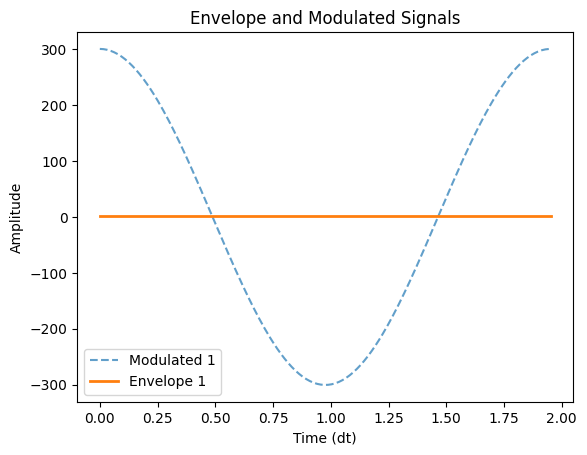

In [35]:
# now introducing the pulse 
# single period Pulse
wp = np.abs(qubit1.freq - qubit2.freq)
T = 2 * np.pi / wp
period_time = np.linspace(0, T, 250)  # a single period of the pulse
args = {"shape": Pulse.constant}
pulse = Pulse(omega=wp, amp=300.5)
Pulse.plot_pulse([(pulse, args)], period_time)

H_pump = qs.hamiltonian.driven_term(snail_mode=snail)
H = [qs.hamiltonian.H0, [H_pump, pulse.drive]]

In [36]:
# comparing the rho vs psi method of the mesolver
result_psi0_mesolve = qt.mesolve(H = H, rho0 = psi0, tlist = tlist, options = opts)

10.1%. Run time:   0.66s. Est. time left: 00:00:00:05
20.2%. Run time:   1.35s. Est. time left: 00:00:00:05
30.3%. Run time:   2.05s. Est. time left: 00:00:00:04
40.4%. Run time:   2.79s. Est. time left: 00:00:00:04
50.5%. Run time:   3.50s. Est. time left: 00:00:00:03
60.6%. Run time:   4.20s. Est. time left: 00:00:00:02
70.7%. Run time:   4.91s. Est. time left: 00:00:00:02
80.8%. Run time:   5.60s. Est. time left: 00:00:00:01
90.9%. Run time:   6.31s. Est. time left: 00:00:00:00
100.0%. Run time:   6.93s. Est. time left: 00:00:00:00
Total run time:   6.93s


In [37]:
result_rho0_mesolve = qt.mesolve(H = H, rho0 = rho0, tlist = tlist, options = opts)

10.1%. Run time:  65.25s. Est. time left: 00:00:09:40
20.2%. Run time: 132.71s. Est. time left: 00:00:08:44
30.3%. Run time: 204.03s. Est. time left: 00:00:07:49
40.4%. Run time: 276.91s. Est. time left: 00:00:06:48
50.5%. Run time: 350.65s. Est. time left: 00:00:05:43
60.6%. Run time: 426.44s. Est. time left: 00:00:04:37
70.7%. Run time: 502.65s. Est. time left: 00:00:03:28
80.8%. Run time: 576.59s. Est. time left: 00:00:02:16
90.9%. Run time: 656.36s. Est. time left: 00:00:01:05
100.0%. Run time: 723.41s. Est. time left: 00:00:00:00
Total run time: 723.41s


C:\Users\girgi\AppData\Local\Temp\ipykernel_4504\4028086070.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


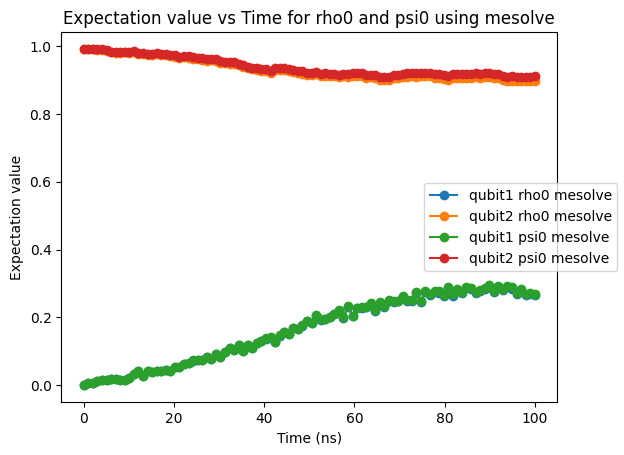

In [38]:
# plotting the data
expect_qubit1_rho0 = []
expect_qubit2_rho0 = []
expect_qubit1_psi0 = []
expect_qubit2_psi0 = []

for i in range(len(result_rho0_mesolve.states)):
    expect_qubit1_rho0.append(np.real(qt.expect(qs.modes_num[qubit1], result_rho0_mesolve.states[i])))
    expect_qubit2_rho0.append(np.real(qt.expect(qs.modes_num[qubit2], result_rho0_mesolve.states[i])))
    expect_qubit1_psi0.append(np.real(qt.expect(qs.modes_num[qubit1], result_psi0_mesolve.states[i])))
    expect_qubit2_psi0.append(np.real(qt.expect(qs.modes_num[qubit2], result_psi0_mesolve.states[i])))

fig, axs = plt.subplots(1)
axs.plot(tlist, expect_qubit1_rho0, label = "qubit1 rho0 mesolve", marker = "o")
axs.plot(tlist, expect_qubit2_rho0, label = "qubit2 rho0 mesolve", marker = "o")
axs.plot(tlist, expect_qubit1_psi0, label = "qubit1 psi0 mesolve", marker = "o")
axs.plot(tlist, expect_qubit2_psi0, label = "qubit2 psi0 mesolve", marker = "o")
axs.set_xlabel("Time (ns)")
axs.set_ylabel("Expectation value")
axs.set_title("Expectation value vs Time for rho0 and psi0 using mesolve")

fig.legend(loc = 'right')
fig.show()

In [39]:
# build the propagator element 
U = qt.propagator(H = H, t = tlist, options = opts)

10.1%. Run time:  28.89s. Est. time left: 00:00:04:17
20.2%. Run time:  57.56s. Est. time left: 00:00:03:47
30.3%. Run time:  87.86s. Est. time left: 00:00:03:22
40.4%. Run time: 117.81s. Est. time left: 00:00:02:53
50.5%. Run time: 147.93s. Est. time left: 00:00:02:24
60.6%. Run time: 176.97s. Est. time left: 00:00:01:55
70.7%. Run time: 206.27s. Est. time left: 00:00:01:25
80.8%. Run time: 235.80s. Est. time left: 00:00:00:56
90.9%. Run time: 265.22s. Est. time left: 00:00:00:26
100.0%. Run time: 292.46s. Est. time left: 00:00:00:00
Total run time: 292.46s


C:\Users\girgi\AppData\Local\Temp\ipykernel_4504\1739159667.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


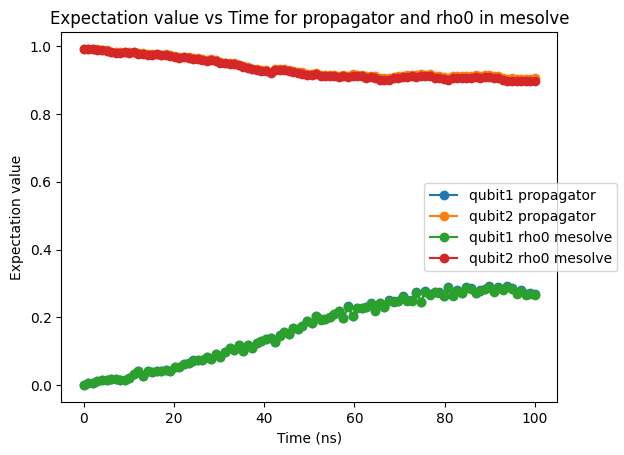

In [40]:
expect_qubit1_prop = []
expect_qubit2_prop = []

for i in range(len(tlist)):
    expect_qubit1_prop.append(np.real(qt.expect(qs.modes_num[qubit1], U[i] * psi0)))
    expect_qubit2_prop.append(np.real(qt.expect(qs.modes_num[qubit2], U[i] * psi0)))

fig, axs = plt.subplots()
axs.plot(tlist, expect_qubit1_prop, label = "qubit1 propagator", marker = "o")
axs.plot(tlist, expect_qubit2_prop, label = "qubit2 propagator", marker = "o")
axs.plot(tlist, expect_qubit1_rho0, label = "qubit1 rho0 mesolve", marker = "o")
axs.plot(tlist, expect_qubit2_rho0, label = "qubit2 rho0 mesolve", marker = "o")
axs.set_xlabel("Time (ns)")
axs.set_ylabel("Expectation value")
axs.set_title("Expectation value vs Time for propagator and rho0 in mesolve")

fig.legend(loc = "right")
fig.show()

C:\Users\girgi\AppData\Local\Temp\ipykernel_4504\522936034.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


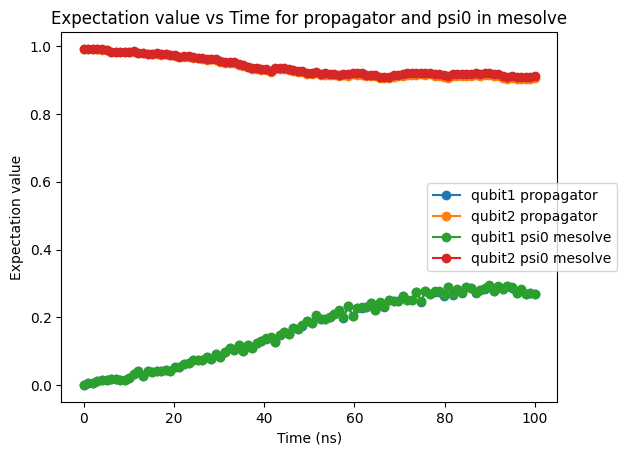

In [41]:
fig, axs = plt.subplots()
axs.plot(tlist, expect_qubit1_prop, label = "qubit1 propagator", marker = "o")
axs.plot(tlist, expect_qubit2_prop, label = "qubit2 propagator", marker = "o")
axs.plot(tlist, expect_qubit1_psi0, label = "qubit1 psi0 mesolve", marker = "o")
axs.plot(tlist, expect_qubit2_psi0, label = "qubit2 psi0 mesolve", marker = "o")
axs.set_xlabel("Time (ns)")
axs.set_ylabel("Expectation value")
axs.set_title("Expectation value vs Time for propagator and psi0 in mesolve")

fig.legend(loc = "right")
fig.show()

In [ ]:
# conclusion: all of them are pretty much the same with the options set above 